LSTM

Import packages.

In [7]:
import torch
import os
import csv
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
import keras
import tensorflow as tf

from torch.nn.utils.rnn import pad_sequence
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

Download the dataset and unzip it.

In [8]:
!gdown 1wdlmKyBxd3_UdwOaNgfwx6mt6DMas6uS
!gdown 1E22shQHUmSvqkLPe6qGji4TIYArtOAKf
!gdown 141AattP4xJ3fm2n9ZWFh1wvSfwVOl7cT
!gdown 1XUa6TMZ_ytk3I_jQRJ0iC7tHQWUAZghw
!gdown 1FIMWCzeRN9C6NurXyq4NnnUc5W1DeMDk
!gdown 1n4haJzeyPJxPm2ukVBg1sM84CSmJimV8


!gdown 1RKM_eyCjuUPG50Kl6azWnkOaPkHObBld
!gdown 1IncHTNbn7GJ69tCHzKDRpNPTYKzX7Ias
!gdown 1dq2zpR9N0OXtqR-qhQE0ny5H1RT4oOG7
!gdown 16Ll_Q041wFe1PSGULeLph3oQSKH6_yNg
!gdown 1qhkb3-__1Ubl47Sicsfniy1JtDUXE0Zf

Downloading...
From: https://drive.google.com/uc?id=1wdlmKyBxd3_UdwOaNgfwx6mt6DMas6uS
To: /content/train_y.csv
100% 180k/180k [00:00<00:00, 76.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E22shQHUmSvqkLPe6qGji4TIYArtOAKf
To: /content/V_trade.csv
100% 7.28M/7.28M [00:00<00:00, 74.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=141AattP4xJ3fm2n9ZWFh1wvSfwVOl7cT
To: /content/V_remit.csv
100% 2.80M/2.80M [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XUa6TMZ_ytk3I_jQRJ0iC7tHQWUAZghw
To: /content/V_info.csv
100% 533k/533k [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FIMWCzeRN9C6NurXyq4NnnUc5W1DeMDk
To: /content/V_cons.csv
100% 4.96M/4.96M [00:00<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n4haJzeyPJxPm2ukVBg1sM84CSmJimV8
To: /content/V_cred.csv
100% 13.5M/13.5M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RKM_eyCjuUPG50Kl6azWnkOaPkHObBld
To: /content/

Combine all V_ together

In [9]:
V_cred = pd.read_csv("V_cred.csv", index_col=0) 
V_info = pd.read_csv("V_info.csv", index_col=0)             
V_remit = pd.read_csv("V_remit.csv", index_col=0) 
V_cons = pd.read_csv("V_cons.csv", index_col=0)             
V_trade = pd.read_csv("V_trade.csv", index_col=0) 
train_y = pd.read_csv("train_y.csv", index_col=0)

V_cred_public = pd.read_csv("V_cred_public.csv", index_col=0) 
V_info_public = pd.read_csv("V_info_public.csv", index_col=0)             
V_remit_public = pd.read_csv("V_remit_public.csv", index_col=0) 
V_cons_public = pd.read_csv("V_cons_public.csv", index_col=0)             
V_trade_public = pd.read_csv("V_trade_public.csv", index_col=0) 

print(V_cred.shape)
print(V_info.shape)
print(V_remit.shape)
print(V_cons.shape)
print(V_trade.shape)
print(train_y.shape)

V_cons.iloc[:,1] = V_cons.iloc[:,1].replace([130], 0)
V_cons.iloc[:,2] = V_cons.iloc[:,2].replace([47], 0)

V_part = [ pd.concat([V_info, 
                      V_cred.iloc[:,8*i:8*(i+1)],
                      V_remit.iloc[:,3*i:3*(i+1)],
                      V_cons.iloc[:,4*i:4*(i+1)],
                      V_trade.iloc[:,7*i:7*(i+1)]], axis=1) for i in range (13)]
#V_part = [ pd.concat([V_info.iloc[:,[0,2]], 
#                      V_cred.iloc[:,[8*i+j for j in [0,1,2,6]]],
#                      V_remit.iloc[:,[3*i+j for j in [0,2]]],
#                      V_cons.iloc[:,[4*i+j for j in [0,3]]],
#                      V_trade.iloc[:,[7*i+j for j in [0,2,4,5,6]]]], axis=1) for i in range (13)]
V_all = pd.concat([V_part[i] for i in range (13)], axis = 1)
V_all = (V_all-V_all.mean())/V_all.std()
print(V_all.shape) # put all data together (23906 * 338)

V_part_public = [ pd.concat([V_info_public, 
                      V_cred_public.iloc[:,8*i:8*(i+1)],
                      V_remit_public.iloc[:,3*i:3*(i+1)],
                      V_cons_public.iloc[:,4*i:4*(i+1)],
                      V_trade_public.iloc[:,7*i:7*(i+1)]], axis=1) for i in range (13)]
#V_part_public = [ pd.concat([V_info_public.iloc[:,[0,2]], 
#                      V_cred_public.iloc[:,[8*i+j for j in [0,1,2,6]]],
#                      V_remit_public.iloc[:,[3*i+j for j in [0,2]]],
#                      V_cons_public.iloc[:,[4*i+j for j in [0,3]]],
#                      V_trade_public.iloc[:,[7*i+j for j in [0,2,4,5,6]]]], axis=1) for i in range (13)]
V_all_public = pd.concat([V_part_public[i] for i in range (13)], axis = 1)
V_all_public = (V_all_public-V_all_public.mean())/V_all_public.std()
print(V_all_public.shape) # put all data together (1845 * 338)


(23906, 104)
(23906, 4)
(23906, 39)
(23906, 52)
(23906, 91)
(23906, 1)
(23906, 338)
(1845, 338)


oversampling (we modified weights in data instead)

In [10]:
'''
SAR_idx = []
for i in range (len(train_y)):
    if (train_y.iloc[i,0] == 1):
        SAR_idx.append(i)
print(len(SAR_idx), SAR_idx)

for i in range (len(SAR_idx)):
    if (i % 10 == 0):
        print(i, "/", len(SAR_idx)) 
    for j in range (30):
        V_all.loc[len(V_all)] = V_all.loc[SAR_idx[i]]
        train_y.loc[len(train_y)] = train_y.loc[SAR_idx[i]]
'''
print(V_all.shape, train_y.shape)

(23906, 338) (23906, 1)


Define model

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units = 32, return_sequences = True,
                            input_shape = (13,V_all.shape[1]//13)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='sigmoid'))
model.add(keras.layers.LSTM(units = 32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='sigmoid'))
model.add(keras.layers.LSTM(units = 32))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam')

#model = keras.models.load_model('path/to/location')


tempx = np.array(V_all)
tempy = np.array(train_y)
tempx = np.reshape(tempx, (tempx.shape[0], 13, -1))
tempx[np.isnan(tempx)] = 0

testx = np.array(V_all_public)
testx = np.reshape(testx, (testx.shape[0], 13, -1))
testx[np.isnan(testx)] = 0


Training

Epoch 1/100
598/598 [==============================] - 21s 24ms/step - loss: 1.4939 - val_loss: 0.8833
Epoch 2/100
598/598 [==============================] - 13s 22ms/step - loss: 1.3790 - val_loss: 0.4234
Epoch 3/100
598/598 [==============================] - 13s 22ms/step - loss: 1.3464 - val_loss: 0.8153
Epoch 4/100
598/598 [==============================] - 15s 25ms/step - loss: 1.2897 - val_loss: 0.7243
Epoch 5/100
598/598 [==============================] - 13s 22ms/step - loss: 1.2944 - val_loss: 0.6301
Epoch 6/100
598/598 [==============================] - 13s 22ms/step - loss: 1.2514 - val_loss: 0.7253
Epoch 7/100
598/598 [==============================] - 13s 22ms/step - loss: 1.2358 - val_loss: 0.8173
Epoch 8/100
598/598 [==============================] - 14s 23ms/step - loss: 1.2128 - val_loss: 0.7169
Epoch 9/100
598/598 [==============================] - 17s 28ms/step - loss: 1.1895 - val_loss: 0.7730
Epoch 10/100
598/598 [==============================] - 16s 26ms/step - l

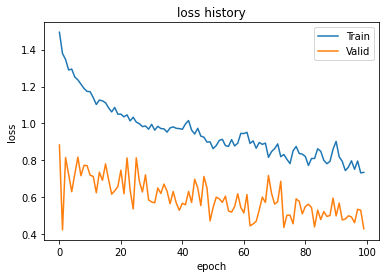

updating: model.pth/ (stored 0%)
updating: model.pth/variables/ (stored 0%)
updating: model.pth/variables/variables.index (deflated 70%)
updating: model.pth/variables/variables.data-00000-of-00001 (deflated 9%)
updating: model.pth/saved_model.pb (deflated 91%)
updating: model.pth/assets/ (stored 0%)
updating: model.pth/keras_metadata.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
def print_result(model, x, y):
    prediction = model.predict(x)
    print(prediction, prediction.shape)
    result = pd.concat([pd.DataFrame(prediction, columns=["prob"]), pd.DataFrame(y)], axis=1) 
    result = result.sort_values(by = 'prob')
    print(result)
    for i in range (len(result)):
        if (result.iloc[i,1] == 1):
            print("The", i, "th lowest prediction has SAR with prob", result.iloc[i,0])

import matplotlib.pyplot as plt

history = model.fit(tempx, tempy, epochs = 100, batch_size = 32, class_weight = {0:1, 1:100}, validation_split=0.2, shuffle=True)

model.save('model.pth')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Valid'])
plt.show()
 

!zip -r model.zip model.pth
from google.colab import files
files.download("model.zip")

prediction = model.predict(testx)

If you want to directly play with model.zip, you can directly run this part

In [22]:
!unzip model.zip
model = keras.models.load_model('model.pth')
prediction = model.predict(testx)

Archive:  model.zip
replace model.pth/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model.pth/variables/variables.index  
  inflating: model.pth/variables/variables.data-00000-of-00001  
  inflating: model.pth/saved_model.pb  
  inflating: model.pth/keras_metadata.pb  
58/58 [==============================] - 2s 7ms/step
